In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import spectrogram, bode
from scipy.signal import cwt, ricker
from scipy.signal import butter, filtfilt
from src.data_processing import process_file
from src.plotting import (
    plot_measured_I, 
    plot_measured_q, 
    plot_measured_q_dot,
    plot_measured_U
)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def fit_percentage(y_true, y_pred):
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    fit_perc = (1 - numerator/denominator) * 100
    return fit_perc


# Time-domain plot
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['U'], label='Input Signal')
# plt.title('Time-domain Signal')
plt.ylabel('Voltage [V]')
plt.legend()
plt.xticks([0, 33, 66, 100, 133, 166, 200])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.grid(which='major', axis='x', linestyle='--', color='gray')
plt.grid(which='major', axis='y', linestyle='--', color='gray')

plt.subplot(2, 1, 2)
plt.plot(df['timestamp'], df['θ(t)'], label='Output Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Position [rad]')
plt.legend()
plt.tight_layout()
plt.xticks([0, 33, 66, 100, 133, 166, 200])
plt.yticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
plt.grid(which='major', axis='x', linestyle='--', color='gray')
plt.grid(which='major', axis='y', linestyle='--', color='gray')

plt.show()





In [17]:
file_names = ["exp2_square", "exp2_tooth", "exp2_triangle", "exp3_square_1_5", "exp3_tooth_1_5", "exp3_triangle_1_5", "pwm_ctrl_slow", "pwm_ctrl_fast"]
base_path = "/Users/simondeligne/Dionysos/thesis_model_dxl/data/validation_exp/acceleration_analysis/"
file_name = file_names[0]
# Process real data
real_data_path = f"{base_path}real_data/{file_name}.csv"
df = pd.read_csv(real_data_path)

# Process simulation data
simulation_path = f"{base_path}simulation/{file_name}.csv"
sim_df = pd.read_csv(simulation_path)
acc_sim_interpolated = np.interp(df['timestamp'], sim_df['time'], sim_df['acc_sim'])


# Calculate sampling interval and frequency
T = np.mean(np.diff(df['timestamp']))
fs = 1.0 / T

# Filter requirements.
order = 6
fs = 1.0 / np.mean(np.diff(df['timestamp']))      # sample rate, Hz
cutoff = 5  # desired cutoff frequency of the filter, Hz

# Apply the filter to the position data
position_smoothed = butter_lowpass_filter(df['θ(t)'], cutoff, fs, order)

# Differentiate the smoothed position to get velocity
velocity_from_smoothed_position = np.gradient(position_smoothed, df['timestamp'])

# Differentiate the original position data to get velocity for comparison
velocity_from_original_position = np.gradient(df['θ(t)'], df['timestamp'])

# Compute acceleration from the velocity derived from the filtered/smoothed position
acceleration_from_filtered_velocity = np.gradient(velocity_from_smoothed_position, df['timestamp'])


In [6]:
file_path = "/Users/simondeligne/Dionysos/thesis_model_dxl/data/used_reference_trajectories/Xing_trajectories/measures_interpolated/simu_fast_smooth_tsit.csv"
# file_path = "/Users/simondeligne/Dionysos/thesis_model_dxl/data/used_reference_trajectories/Xing_trajectories/measures_interpolated/simu_slow_smooth_tsit.csv"

sim_df = pd.read_csv(file_path)

# Interpolating simulated acceleration onto the real dataset's time stamps
acc_sim_interpolated = np.interp(df['timestamp'], sim_df['time'], sim_df['acc_sim'])
# Assuming acceleration_from_filtered_velocity is the real acceleration computed earlier
error_acc = acceleration_from_filtered_velocity - acc_sim_interpolated

# Calculate NRMSE
nrmse = np.sqrt(np.mean(error_acc ** 2)) / (np.max(acceleration_from_filtered_velocity) - np.min(acceleration_from_filtered_velocity))

# Define a threshold for the percentage fit calculation, e.g., within 10% of the max acceleration range
threshold = 0.1 * (np.max(acceleration_from_filtered_velocity) - np.min(acceleration_from_filtered_velocity))
percentage_fit = np.mean(np.abs(error_acc) < threshold) * 100

R2 = fit_percentage(acceleration_from_filtered_velocity, acc_sim_interpolated)
# Print NRMSE and Percentage Fit for verification
print(f"NRMSE: {nrmse:.4f}")
print(f"Percentage Fit within {threshold:.4f} rad/s² threshold: {percentage_fit:.2f}%")
print(f"Percentage Fit R-squared : {R2}%")

NRMSE: 0.0553
Percentage Fit within 4.1898 rad/s² threshold: 90.47%
Percentage Fit R-squared : 92.42279664519832%


In [15]:
file_names = ["exp2_square", "exp2_tooth", "exp2_triangle", "exp3_square_1_5", "exp3_tooth_1_5", "exp3_triangle_1_5", "pwm_ctrl_slow", "pwm_ctrl_fast"]
base_path = "/Users/simondeligne/Dionysos/thesis_model_dxl/data/validation_exp/acceleration_analysis/"

results = []

for file_name in file_names:
    # Process real data
    real_data_path = f"{base_path}real_data/{file_name}.csv"
    df = pd.read_csv(real_data_path)
    
    # Process simulation data
    simulation_path = f"{base_path}simulation/{file_name}.csv"
    sim_df = pd.read_csv(simulation_path)
    acc_sim_interpolated = np.interp(df['timestamp'], sim_df['time'], sim_df['acc_sim'])

    # Filtering and differentiation
    fs = 1.0 / np.mean(np.diff(df['timestamp']))
    cutoff = 5
    order = 6
    df['smoothed_position'] = butter_lowpass_filter(df['θ(t)'], cutoff, fs, order)
    df['velocity'] = np.gradient(df['smoothed_position'], df['timestamp'])
    df['acceleration'] = np.gradient(df['velocity'], df['timestamp'])

    # Error calculation
    error_acc = df['acceleration'] - acc_sim_interpolated
    nrmse = np.sqrt(np.mean(error_acc ** 2)) / (np.max(df['acceleration']) - np.min(df['acceleration']))
    threshold = 0.1 * (np.max(df['acceleration']) - np.min(df['acceleration']))
    percentage_fit = np.mean(np.abs(error_acc) < threshold) * 100
    R2 = fit_percentage(df['acceleration'], acc_sim_interpolated)

    results.append({
        'File': file_name,
        'NRMSE': nrmse,
        'Percentage Fit': percentage_fit,
        'R2': R2
    })

# Print or save results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv(f"{base_path}summary_results.csv", index=False)


                File     NRMSE  Percentage Fit          R2
0        exp2_square  0.061606       91.632008   74.720130
1         exp2_tooth  0.084325       88.026644   49.928400
2      exp2_triangle  0.098032       78.419301   34.341512
3    exp3_square_1_5  0.074188       89.560440   56.512782
4     exp3_tooth_1_5  0.146391       84.085234 -112.265662
5  exp3_triangle_1_5  0.227689       61.416667 -166.067657
6      pwm_ctrl_slow  0.061010       93.025019   90.822052
7      pwm_ctrl_fast  0.055498       90.573013   92.429997


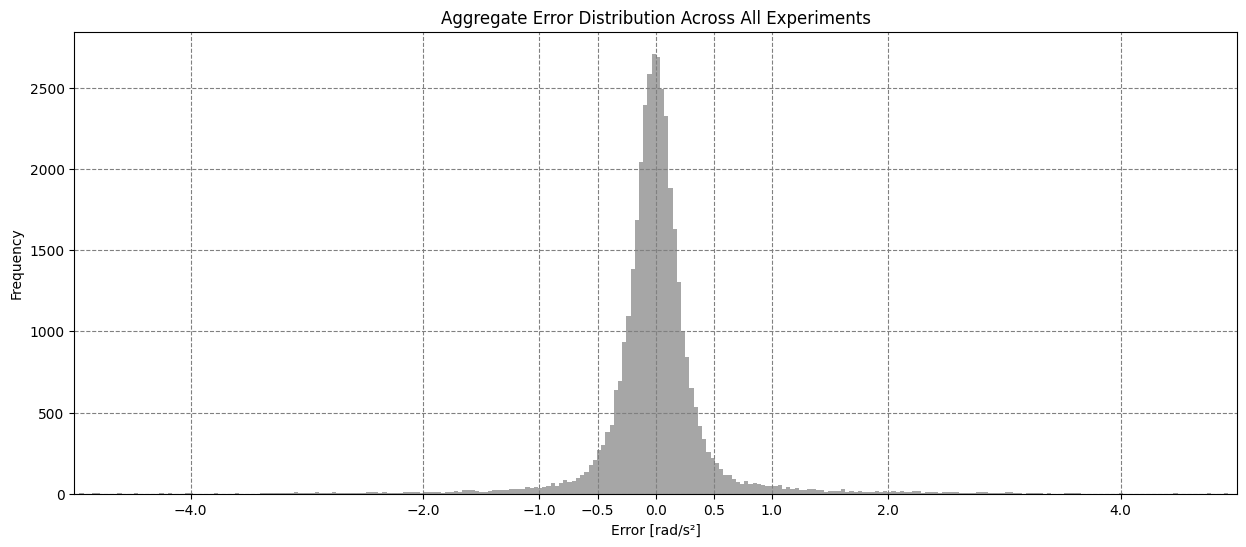

In [25]:
file_names = ["exp2_square", "exp2_tooth", "exp2_triangle", "exp3_square_1_5", "exp3_tooth_1_5", "exp3_triangle_1_5", "pwm_ctrl_slow", "pwm_ctrl_fast"]
base_path = "/Users/simondeligne/Dionysos/thesis_model_dxl/data/validation_exp/acceleration_analysis/"

results = []

all_errors = []  # List to collect all errors from all files

for file_name in file_names:
    # Process real data
    real_data_path = f"{base_path}real_data/{file_name}.csv"
    df = pd.read_csv(real_data_path)
    
    # Process simulation data
    simulation_path = f"{base_path}simulation/{file_name}.csv"
    sim_df = pd.read_csv(simulation_path)
    acc_sim_interpolated = np.interp(df['timestamp'], sim_df['time'], sim_df['acc_sim'])

    fs = 1.0 / np.mean(np.diff(df['timestamp']))
    cutoff = 5
    order = 6
    position_smoothed = butter_lowpass_filter(df['θ(t)'], cutoff, fs, order)
    velocity_from_smoothed_position = np.gradient(position_smoothed, df['timestamp'])
    acceleration_from_filtered_velocity = np.gradient(velocity_from_smoothed_position, df['timestamp'])

    error_acc = acceleration_from_filtered_velocity - acc_sim_interpolated
    all_errors.extend(error_acc)  # Collect all errors into the list

# Plotting the aggregated error distribution across all experiments
plt.figure(figsize=(15, 6))
plt.hist(all_errors, bins=1000, color='gray', alpha=0.7)
plt.xlabel('Error [rad/s²]')
plt.ylabel('Frequency')
plt.title('Aggregate Error Distribution Across All Experiments')

plt.xticks([-4, -2, -1, -0.5, 0, 0.5, 1, 2, 4])
plt.grid(which='major', axis='x', linestyle='--', color='gray')
plt.grid(which='major', axis='y', linestyle='--', color='gray')

plt.xlim(-5, 5)
plt.show()


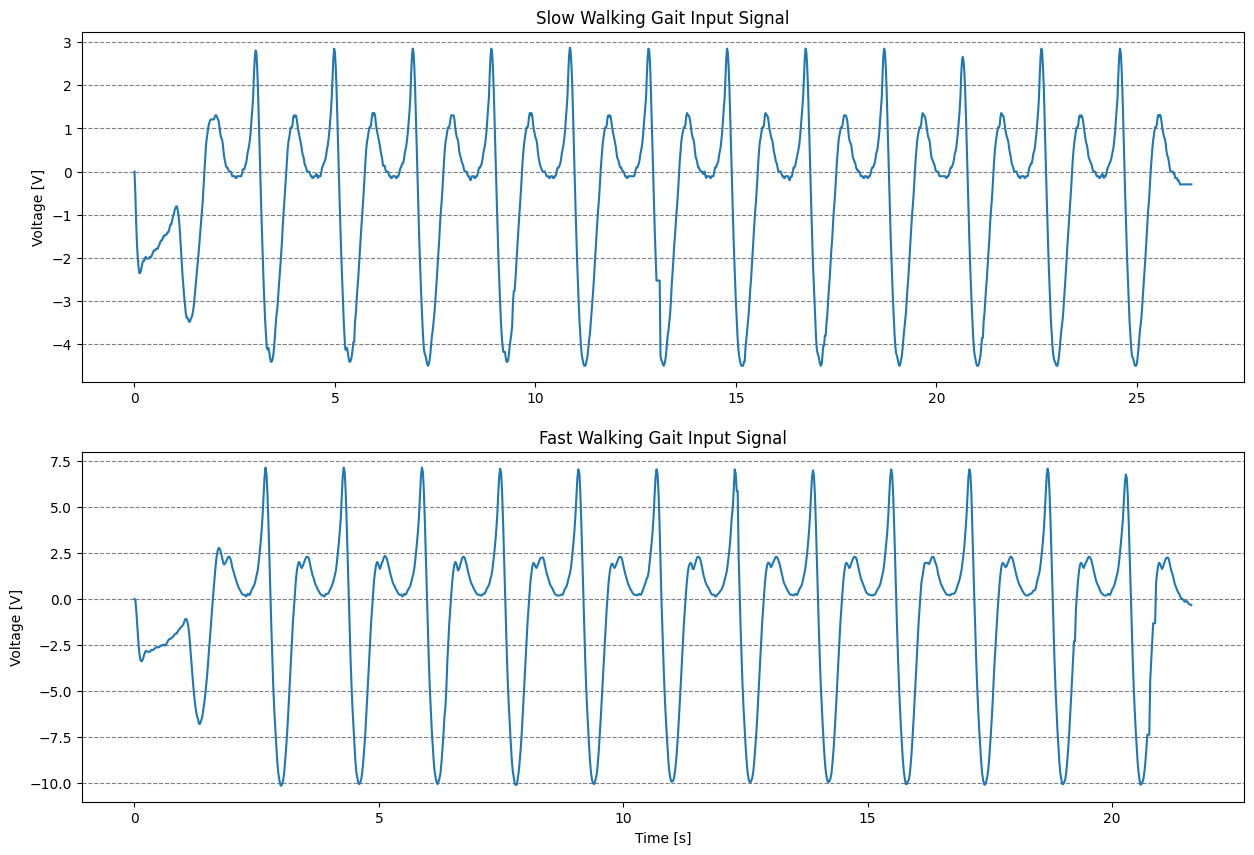

In [35]:
file_names = ["pwm_ctrl_slow", "pwm_ctrl_fast"]
base_path = "/Users/simondeligne/Dionysos/thesis_model_dxl/data/validation_exp/acceleration_analysis/"

results = []

all_errors = []  # List to collect all errors from all files

plt.figure(figsize=(15, 10))
i = 1
for file_name in file_names:
    # Process real data
    real_data_path = f"{base_path}real_data/{file_name}.csv"
    df = pd.read_csv(real_data_path)
    plt.subplot(2, 1, i)
    plt.plot(df['timestamp'], df['U'], label=f'{file_name} - Real Data')
    plt.grid(which='major', axis='y', linestyle='--', color='gray')
    if i == 1:
        plt.title('Slow Walking Gait Input Signal')
    else:
        plt.title('Fast Walking Gait Input Signal')
    plt.ylabel('Voltage [V]')

    i = i + 1
    
plt.xlabel('Time [s]')
plt.show()